In [42]:
import numpy as np
import pandas as pd
import string
import pickle

import sklearn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize

## Data Loading and Splits

In [43]:
filename = 'classification_data/final_annotated_data_consistent.csv'
df = pd.read_csv(filename)

print(df.is_answerable_orig.value_counts())
print('Total', len(df))

N    1574
S    1034
Y    1020
Name: is_answerable_orig, dtype: int64
Total 3629


In [44]:
def print_stats(df, name='df'):
    print(name.upper())
    print('Length = %d' % len(df))
    print('IsAnswerableOrig Counts')
    print(df.is_answerable_orig.value_counts())
    print('IsAnswerableNew Counts')
    print(df.is_answerable_new.value_counts())
    print()

In [45]:
train_df = df[~df.expert]
test_df = df[df.expert]
test_df = test_df[test_df.is_answerable_new.notnull()]

print_stats(train_df, 'train')
print_stats(test_df, 'test')

TRAIN
Length = 3348
IsAnswerableOrig Counts
N    1436
S     958
Y     954
Name: is_answerable_orig, dtype: int64
IsAnswerableNew Counts
Series([], Name: is_answerable_new, dtype: int64)

TEST
Length = 281
IsAnswerableOrig Counts
N    138
S     76
Y     66
Name: is_answerable_orig, dtype: int64
IsAnswerableNew Counts
N    134
S     77
Y     70
Name: is_answerable_new, dtype: int64



In [46]:
# Column Renames
cols = ['question', 'review0', 'review1', 'review2', 'review3', 'review4', 'is_answerable']

train_df = train_df.rename(columns={'is_answerable_orig': 'is_answerable'})[cols]

test_df = test_df.rename(columns={'is_answerable_orig': 'is_answerable', 
                                  'is_answerable_new': 'is_answerable_human'})[cols + ['is_answerable_human']]


def filter_data(df):
    print(len(df))
    df = df[df.is_answerable.notnull()]
    print(len(df))
    df = df[df.review0.notnull()]
    print(len(df))
    return df

train_df = filter_data(train_df)

print('\n')

test_df = filter_data(test_df)
test_df_human = test_df[test_df.is_answerable_human.notnull()]
print(len(test_df))

3348
3348
3303


281
280
134
134


In [47]:
train_df, validate_df = np.split(train_df.sample(frac=1), [int(.8*len(train_df))])

In [48]:
len(train_df), len(validate_df), len(test_df)

(2642, 661, 134)

In [49]:
def labels(df):
    df['label'] = df.is_answerable.apply(lambda x: label_map[x])
    return df['label']

def get_reviews(row):
    all_reviews = ''
    for key in ['review0', 'review1', 'review2', 'review3', 'review4']:
        if not isinstance(row[key], float):
            all_reviews += row[key].strip(' ').strip('-')
            all_reviews += ' '
    return all_reviews.strip()

def add_reviews(df):
    df['reviews'] = df.apply(lambda x: get_reviews(x), axis = 1)
    return df

def remove_non_answerable(df):
    return df[df.label != 2]

label_map = {'N': 2, 'S': 0, 'Y': 1, 'A': 1}
for i, j in zip([1, 2, 3], [1, 0, 2]):
    label_map[i] = j
    label_map[str(i)] = j

train_df, test_df, validate_df = list(map(add_reviews, [train_df, test_df, validate_df]))
train_labels, test_labels, validate_labels = list(map(labels, [train_df, test_df, validate_df]))
train_df, test_df, validate_df = list(map(remove_non_answerable, [train_df, test_df, validate_df]))

len(train_df), len(validate_df), len(test_df)

(1518, 384, 69)

## TF IDF Vectorizer

In [50]:
"""
df = pd.read_csv('classification_data/train-qar_sample_100000.csv')
df = add_reviews(df)
print(len(df))

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))

with open('classification_data/q_classification_vectorizer.pkl', 'wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
"""

"\ndf = pd.read_csv('classification_data/train-qar_sample_100000.csv')\ndf = add_reviews(df)\nprint(len(df))\n\ntfidf_vectorizer = TfidfVectorizer(stop_words='english')\ntfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))\n\nwith open('classification_data/q_classification_vectorizer.pkl', 'wb') as fp:\n    pickle.dump(tfidf_vectorizer, fp)\n"

In [51]:
with open('classification_data/q_classification_vectorizer.pkl', 'rb') as fp:
    tfidf_vectorizer = pickle.load(fp)

In [52]:
len(tfidf_vectorizer.vocabulary_)

158752

## w2v Vectorizer

In [53]:
import numpy as np

# with open("classification_data/glove.6B.300d.txt", "rb") as lines:
#     w2v = {str(line.split()[0].decode('UTF-8')): np.array(list(map(float, line.split()[1:])))
#            for line in lines}

In [54]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 300

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [55]:
with open('classification_data/q_classification_w2v_vectorizer.pkl', 'rb') as fp:
    w2v_vectorizer = pickle.load(fp)

In [56]:
# w2v_vectorizer = MeanEmbeddingVectorizer(w2v)

In [57]:
# with open('classification_data/q_classification_w2v_vectorizer.pkl', 'wb') as fp:
#     pickle.dump(w2v_vectorizer, fp)

## Features

In [58]:
df = train_df

In [59]:
train_df_raw, test_df_raw, validate_df_raw = list(map(lambda x: x.copy(), [train_df, test_df, validate_df]))

In [60]:
def tokenize(text):
    punctuations = string.punctuation.replace("\'", '')

    for ch in punctuations:
        text = text.replace(ch, " " + ch + " ")

    tokens = text.split()
    for i, token in enumerate(tokens):
        if not token.isupper():
            tokens[i] = token.lower()
    return tokens

In [61]:
"""
x = vectorizer.transform(['It is a total idiot'])
y = vectorizer.transform(['It is not a total idiocy'])

print(type(x), '|\n', x.shape, '|\n', x, '|\n', len(x.toarray()[0]))
print("-"*50)
print(type(y), '|\n', y.shape, '|\n', y, '|\n', len(y.toarray()[0]))
print("-"*50)
print(x.toarray().dot(y.toarray().transpose())[0][0])
"""

'\nx = vectorizer.transform([\'It is a total idiot\'])\ny = vectorizer.transform([\'It is not a total idiocy\'])\n\nprint(type(x), \'|\n\', x.shape, \'|\n\', x, \'|\n\', len(x.toarray()[0]))\nprint("-"*50)\nprint(type(y), \'|\n\', y.shape, \'|\n\', y, \'|\n\', len(y.toarray()[0]))\nprint("-"*50)\nprint(x.toarray().dot(y.toarray().transpose())[0][0])\n'

In [62]:
def n_intersection(q, r):
    return len(set(q).intersection(set(r)))

def w2v_sim(q, r):
    # dot product of q and r as w2v vectors
    q_vec = w2v_vectorizer.transform([q])
    r_vec = w2v_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose())[0][0]

def tf_idf_sim(q, r):
    # dot product of q and r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    r_vec = tfidf_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose()).toarray()[0][0]

def tf_idf_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def tf_idf_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def add_features(df):
    df['q_tokens'] = df.question.apply(lambda x: tokenize(x))
    df['r_tokens'] = df.reviews.apply(lambda x: tokenize(x))
    df['r_sents'] = df.reviews.apply(lambda x: sent_tokenize(x))
    df['n_q'] = df.q_tokens.apply(lambda x: len(x))
    df['n_r'] = df.r_tokens.apply(lambda x: len(x))
    df['n_intersection'] = df.apply(lambda x: len(set(x.q_tokens).intersection(set(x.r_tokens))), axis=1)
    df['intr_frac'] = df.n_intersection / df.n_q
    df['tfidf'] = df.apply(lambda x: tf_idf_sim(x.question, x.reviews), axis=1)
    df['w2v'] = df.apply(lambda x: w2v_sim(x.question, x.reviews), axis=1)
    df['w2v_sent'] = df.apply(lambda x: w2v_sim_sentence(x.question, x.r_sents), axis=1)
    df['tfidf_sent'] = df.apply(lambda x: tf_idf_sim_sentence(x.question, x.r_sents), axis=1)
    df['w2v_sent_mean'] = df.apply(lambda x: w2v_sim_sentence_mean(x.question, x.r_sents), axis=1)
    df['tfidf_sent_mean'] = df.apply(lambda x: tf_idf_sim_sentence_mean(x.question, x.r_sents), axis=1)
    return df


In [63]:
train_df, test_df, validate_df = list(map(add_features, [train_df_raw, test_df_raw, validate_df_raw]))

In [104]:
# prev_test, prev_val = test_df, validate_df
# test_df = pd.concat([test_df, validate_df], axis=0, sort=False)
# validate_df = test_df
validate_df = prev_val
test_df = prev_test

In [105]:
len(test_df)

69

## Feature Cols

In [106]:
X_cols = ['n_q', 'n_r', 'n_intersection', 'intr_frac']
Y_cols = 'label'

## Analysis

In [107]:
df = train_df

q = df.question.iloc[1]
r = df.reviews.iloc[1]
q_tokens = df.q_tokens.iloc[1]
r_tokens = df.r_tokens.iloc[1]

# q, r, set(q_tokens).intersection(set(r_tokens))

In [108]:
df[[Y_cols] + X_cols].groupby('label').mean()

,n_q,n_r,n_intersection,intr_frac
label,,,,
0,18.42556,370.206851,9.770751,0.563011
1,16.87220,387.038208,9.629776,0.607933


## Training

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X_colss = [
    #X_cols + ['tfidf', 'tfidf_sent'],
    #X_cols + ['w2v', 'w2v_sent'],
    #X_cols + ['w2v_sent_mean', 'tfidf_sent_mean'],
    X_cols + ['w2v_sent', 'tfidf_sent', 'w2v_sent_mean', 'tfidf_sent_mean'],
    X_cols + ['w2v_sent', 'tfidf_sent'],
    
    X_cols + ['tfidf_sent'],
    X_cols + ['w2v_sent'],
    X_cols + ['tfidf', 'tfidf_sent', 'w2v', 'w2v_sent'],
]

n_col_set = len(X_colss)
modelss = []

for j in range(n_col_set):
    models = []
    models.append(LogisticRegression(C=1))
    models.append(LogisticRegression(C=100))
    models.append(DecisionTreeClassifier(max_depth=4))
    models.append(RandomForestClassifier(n_estimators=3, max_depth=4))

    for i in range(len(models)):
        models[i].fit(train_df[X_colss[j]].values, train_df[Y_cols].values)
    modelss.append(models)

/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rchanda/Acads/Fall-2018/Capstone/eqa_

In [124]:
from sklearn.metrics import classification_report

for j, models in enumerate(modelss):
    for i, model in enumerate(models):
        print(j, i)
        predictions = model.predict(validate_df[X_colss[j]].values)
        print(pd.Series(predictions).value_counts())
        print(classification_report(validate_df[Y_cols].values, predictions))

0 0
0    197
1    187
dtype: int64
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       192
           1       0.57      0.55      0.56       192

   micro avg       0.57      0.57      0.57       384
   macro avg       0.57      0.57      0.57       384
weighted avg       0.57      0.57      0.57       384

0 1
0    196
1    188
dtype: int64
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       192
           1       0.55      0.54      0.54       192

   micro avg       0.55      0.55      0.55       384
   macro avg       0.55      0.55      0.55       384
weighted avg       0.55      0.55      0.55       384

0 2
1    216
0    168
dtype: int64
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       192
           1       0.55      0.62      0.58       192

   micro avg       0.56      0.56      0.56       384
   macro avg       0.56

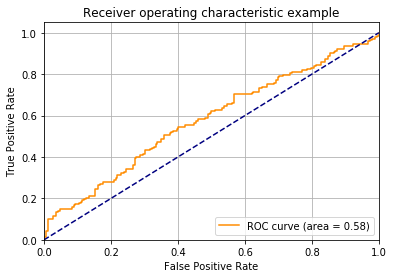

[0.5        0.49869452 0.4973822  0.49606299 0.49736842 0.49604222
 0.4973545  0.49602122 0.49468085 0.496      0.4973262  0.49597855
 0.49731183 0.49595687 0.4972973  0.49593496 0.49456522 0.49591281
 0.49726776 0.49863014 0.5        0.50137741 0.50276243 0.50415512
 0.50555556 0.50696379 0.50558659 0.50420168 0.50561798 0.50704225
 0.50847458 0.50991501 0.51136364 0.50997151 0.50857143 0.50716332
 0.50862069 0.51008646 0.51156069 0.51304348 0.51162791 0.51020408
 0.51169591 0.51026393 0.51176471 0.51032448 0.51183432 0.51335312
 0.51190476 0.51044776 0.50898204 0.51051051 0.50903614 0.50755287
 0.50909091 0.5106383  0.50914634 0.50764526 0.50613497 0.50769231
 0.50925926 0.50773994 0.50621118 0.5046729  0.50625    0.50783699
 0.50943396 0.50788644 0.50949367 0.50793651 0.50636943 0.50798722
 0.50961538 0.50803859 0.50967742 0.51132686 0.50974026 0.51140065
 0.5130719  0.5147541  0.51315789 0.51485149 0.51655629 0.51827243
 0.52       0.52173913 0.52348993 0.52188552 0.52364865 0.5220

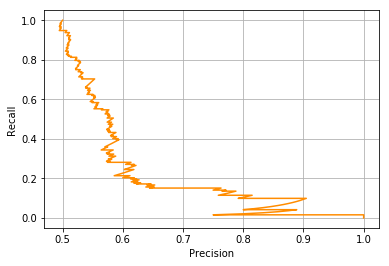

In [125]:
from sklearn.metrics import auc, roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_curves(model):
    probs = model.predict_proba(validate_df[X_colss[4]].values)[:,1]
    ytrue = validate_df[Y_cols].values

    fpr, tpr, thresholds = roc_curve(ytrue, probs, pos_label=1)
    score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    precision, recall, thresholds = precision_recall_curve(ytrue, probs)
    print(precision, recall, thresholds)
    plt.figure()
    plt.plot(precision, recall, color='darkorange')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

    """
    thresholds = [0.25, 0.5, 0.75]
    for th in thresholds:
        #print(probs)
        predictions = [1 if prob > th else 0 for prob in probs]
        #predictions = model.predict(validate_df[X_cols].values)
        print(pd.Series(predictions).value_counts())
        print(classification_report(ytrue, predictions))
    """
    

plot_curves(modelss[4][0])

## Testing

In [133]:
from sklearn.metrics import classification_report

def predictions_k(model, X, k):
    probs = model.predict_proba(X)
    return probs[:, 1] >= k

# modelss = [[model]]
for j, models in enumerate(modelss):
    for i, model in enumerate(models):
        print(j, i)
        predictions = model.predict(test_df[X_colss[j]].values)
        predictions = predictions_k(model, test_df[X_colss[j]].values, 0.6)
        print(pd.Series(predictions).value_counts())
        print(classification_report(test_df[Y_cols].values, predictions))

0 0
False    59
True     10
dtype: int64
              precision    recall  f1-score   support

           0       0.31      0.90      0.46        20
           1       0.80      0.16      0.27        49

   micro avg       0.38      0.38      0.38        69
   macro avg       0.55      0.53      0.36        69
weighted avg       0.66      0.38      0.32        69

0 1
False    56
True     13
dtype: int64
              precision    recall  f1-score   support

           0       0.30      0.85      0.45        20
           1       0.77      0.20      0.32        49

   micro avg       0.39      0.39      0.39        69
   macro avg       0.54      0.53      0.38        69
weighted avg       0.63      0.39      0.36        69

0 2
False    59
True     10
dtype: int64
              precision    recall  f1-score   support

           0       0.25      0.75      0.38        20
           1       0.50      0.10      0.17        49

   micro avg       0.29      0.29      0.29        69
   ma

## Human Performance

In [100]:
predictions = test_df_human.is_answerable_human.apply(lambda x: label_map[x]).values
labels = test_df_human.is_answerable.apply(lambda x: label_map[x]).values
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       0.38      0.45      0.41        20
           1       0.85      0.92      0.88        49
           2       0.91      0.80      0.85        65

   micro avg       0.79      0.79      0.79       134
   macro avg       0.71      0.72      0.71       134
weighted avg       0.81      0.79      0.80       134



## Saving

In [114]:
# with open('classification_data/q_classification_model_final_suggestive.pkl', 'wb') as fp:
#     pickle.dump(modelss[4][0], fp)

In [117]:
with open('classification_data/q_classification_model_final_suggestive.pkl', 'rb') as fp:
    model = pickle.load(fp)

In [122]:
len(test_df)

69